### Treść zadania

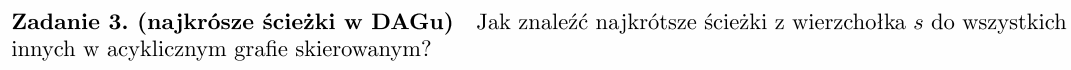

### Omówienie algorytmu

###### Obserwacje
Oczywiście można jak zawsze zastosować algorytm Dijkstry, który w tym przypadku zadziała również dla krawędzi o ujemnych wagach, ponieważ w grafie nie ma cykli, więc nie ma szans, aby algorytm Dijkstry się zapętlił na ujemnym cyklu. Niemniej jednak nie jest to najszybsze rozwiązanie, ponieważ działa ono w czasie $ O(E \cdot log(V)) $, a dla DAGu możemy wyznaczyć najkrótsze ścieżki ważone w czasie liniowym ($ O(V + E) $ lub w czasie $ O(V^2) $ w reprezentacji macierzowej, ale trzymanie DAGu w macierzy nie ma sensu, bo zazwyczaj jest to graf rzadki). Wystarczy zauważyć, że relaksować możemy tylko wierzchołki, do których wychodzą krawędzie z bieżącego wierzchołka oraz to, że jeżeli jakiś wierzchołek nie ma żadnej krawędzi wchodzącej (a taki wierzchołek musi istnieć, bo to DAG, więc gdyby nie było wierzchołka bez krawędzi wchodzących, graf nie byłby DAGiem - miałby cykl), to nie istnieje najkrótsza ścieżka do niego z żadnego innego wierzchołka, więc nigdy nie dokonamy na nim relaksacji. Po tych obserwacjach nasuwa się na myśl algorytm sortowania topologicznego, który w czasie liniowym pozwala nam stwierdzić, z których wierzchołków wychodzą krawędzie do których. W ten sposób otrzymamy posortowanie wierzchołki w taki sposób, że przechodząc liniowo po kolejnych wierzchołkach w uzyskanym porządku, będziemy mieli pewność, że nie mają one krawędzi wychodzących do żadnego z minionych wierzchołków (tych, kóre zostawiliśmy z lewej strony). Można teraz już łatwo zawuażyć, że poprzednie wierzchołki, skoro już nigdy nie będą sprawdzane, powinny zostać zrelaksowane wcześniej, ponieważ nie istnieje do nich już krótsza ścieżka niż ta, którą mogliśmy osiągnąć wcześniej.
###### Algorytm
Najpierw sortujemy topologicznie DAG. Następnie, przechodzimy przez kolejne w tablicy posortowanych topologicznie wierzchołków indeksy wierzchołków i relaksujemy wszystkich sąsiadów tych wierzchołków w sposób analogiczny do algorytmu Dijkstry (jeżeli znaleźliśmy krótszą ścieżkę z bieżącego wierzchołka, to zastępujemy poprzednią długość nową długością). I to już koniec algorytmu.

###### UWAGI
Ponieważ graf jest DAGiem, nie istnieją ścieżki między dowolną parą wierzchołków. Nie możemy w szczególności nigdy przejść przez wierzchołek, który występuje wcześniej w porządku topologicznym.

### Złożoność

###### Obliczeniowa:
$ O(V + E) $  - bo sortowanie topologiczne ma złożoność liniową, a następnie przejście przez graf i relaksacja wierzchołków również odbywa się w czasie liniowym
###### Pamięciowa:
$ O(V) $

### Implementacja

###### UWAGA
W poniższej implementacji wyznaczane są długości najkrótszych ścieżek ze źródła do ujścia (z wierzchołka(-ów), który nie ma krawędzi wchodzących do wierzchołka do wierzchołka(-ów), który nie ma krawędzi wychodzących). Jeżeli chcemy wyznaczyć ścieżkę między dowolnie wskazaną parą wierzchołków, to należy skorzystać z następnego algorytmu.

In [1]:
def topological_sort(G: 'DAG represented by adjacency lists'):
    n = len(G)
    visited = [False] * n
    result = [None] * n
    idx = n
    
    def dfs(u):
        visited[u] = True
        for v, _ in G[u]:
            if not visited[v]:
                dfs(v)
        nonlocal idx
        idx -= 1
        result[idx] = u
        
    for u in range(n):
        if not visited[u]:
            dfs(u)
            
    return result


def shortest_paths(G: 'DAG represented by adjacency lists'):
    n = len(G)
    inf = float('inf')
    weights = [inf] * n
    t_sorted = topological_sort(G)
    weights[t_sorted[0]] = 0
    
    # Relax each neighbour of a vertex
    for u in t_sorted:
        for v, weight in G[u]:
            if weights[u] + weight < weights[v]:
                weights[v] = weights[u] + weight
                
    return weights

###### Kilka testów

##### Pomocnicze

In [2]:
def directed_weighted_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append((e[1], e[2]))
    return G

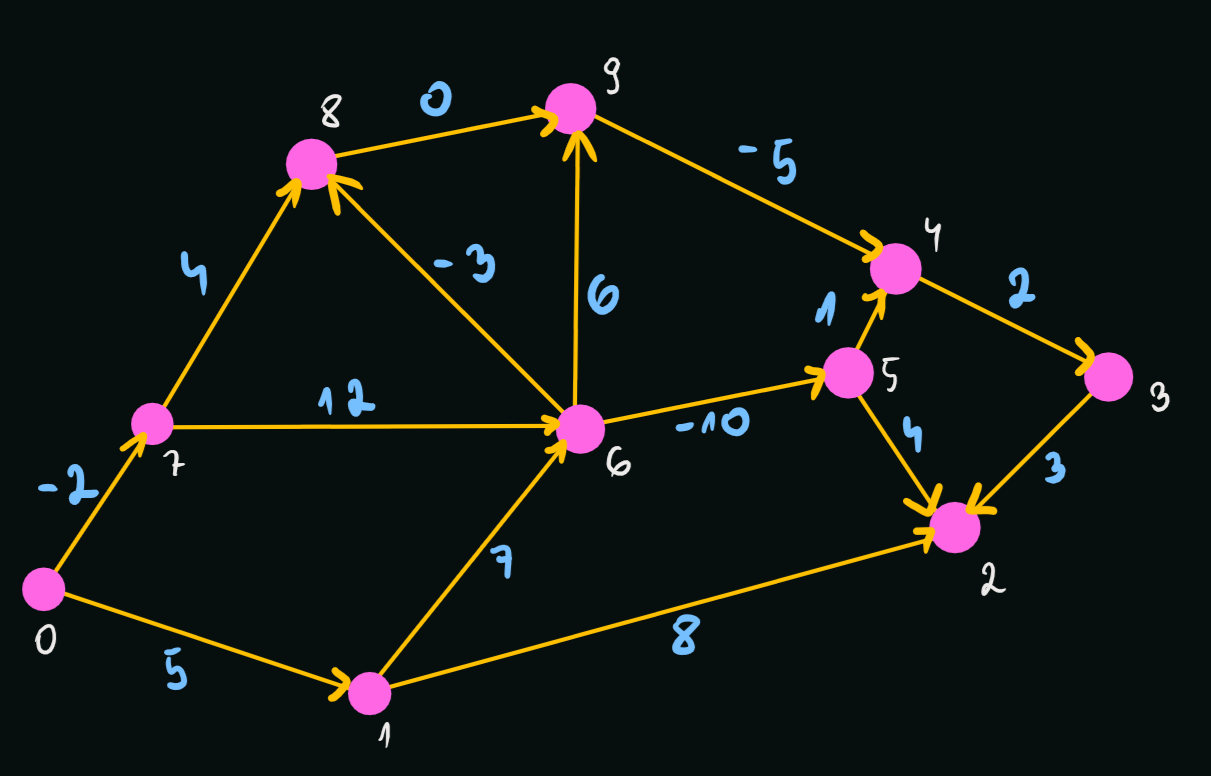

In [3]:
E = [(0, 1, 5), (0, 7, -2), (1, 6, 7), (1, 2, 8), (3, 2, 3), (4, 3, 2), (5, 4, 1), (5, 2, 4), (6, 5, -10),
     (6, 9, 6), (6, 8, -3), (7, 8, 4), (7, 6, 12), (8, 9, 0), (9, 4, -5)]

G = directed_weighted_graph_list(E)

print(shortest_paths(G))

[0, 5, 2, -1, -3, 0, 10, -2, 2, 2]


### (Dodatkowo) Odtwarzanie ścieżek

In [4]:
def topological_sort(G: 'DAG represented by adjacency lists'):
    n = len(G)
    visited = [False] * n
    result = [None] * n
    idx = n
    
    def dfs(u):
        visited[u] = True
        for v, _ in G[u]:
            if not visited[v]:
                dfs(v)
        nonlocal idx
        idx -= 1
        result[idx] = u
        
    for u in range(n):
        if not visited[u]:
            dfs(u)
            
    return result


def get_path(parents, t):
    path = []
    
    while t is not None:
        path.append(t)
        t = parents[t]
        
    path.reverse()
    return path


def shortest_path(G: 'DAG represented by adjacency lists', s: 'start vertex', t: 'target vertex'):
    n = len(G)
    inf = float('inf')
    weights = [inf] * n
    parents = [None] * n
    t_sorted = topological_sort(G)
    weights[s] = 0
    
    # Find the 's' vertex index in a topologically sorted
    # array
    for i in range(n):
        if t_sorted[i] == s:
            break
    
    # Relax each neighbour of a vertex
    for i in range(i, n):
        u = t_sorted[i]
        for v, weight in G[u]:
            if weights[u] + weight < weights[v]:
                weights[v] = weights[u] + weight
                parents[v] = u
                
    return weights[t], get_path(parents, t) if weights[t] < inf else []

###### Kilka testów

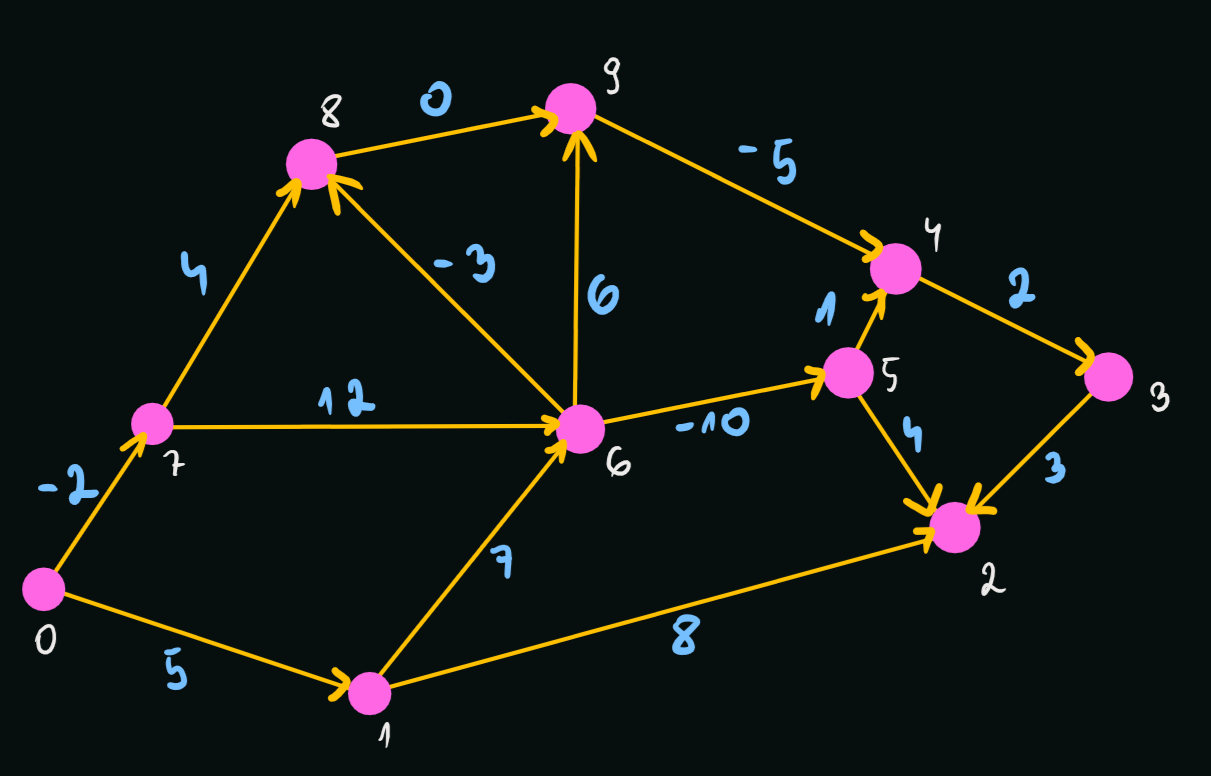

In [5]:
E = [(0, 1, 5), (0, 7, -2), (1, 6, 7), (1, 2, 8), (3, 2, 3), (4, 3, 2), (5, 4, 1), (5, 2, 4), (6, 5, -10),
     (6, 9, 6), (6, 8, -3), (7, 8, 4), (7, 6, 12), (8, 9, 0), (9, 4, -5)]

G = directed_weighted_graph_list(E)

In [6]:
print(shortest_path(G, 0, 2))

(2, [0, 7, 8, 9, 4, 3, 2])


In [7]:
print(shortest_path(G, 2, 0))

(inf, [])


In [8]:
print(shortest_path(G, 0, 5))

(0, [0, 7, 6, 5])


In [9]:
print(shortest_path(G, 0, 3))

(-1, [0, 7, 8, 9, 4, 3])
